In [1]:
import pandas as pd
import numpy as np

/var/folders/zp/c97k147160ddnklbfc2rk3hr0000gn/T/ipykernel_23826/2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_pickle('data/SBAmodel.pickle')
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
df.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,45,1997-02-28,1997,84,4,2,0,0,1,0,0,1,NaN,1999-02-28,60000.0,$0.00,1,0.0,60000.0,48000.0


# Suppression des outliers
https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

## On regarde les distribution en détail suite à SweetViz

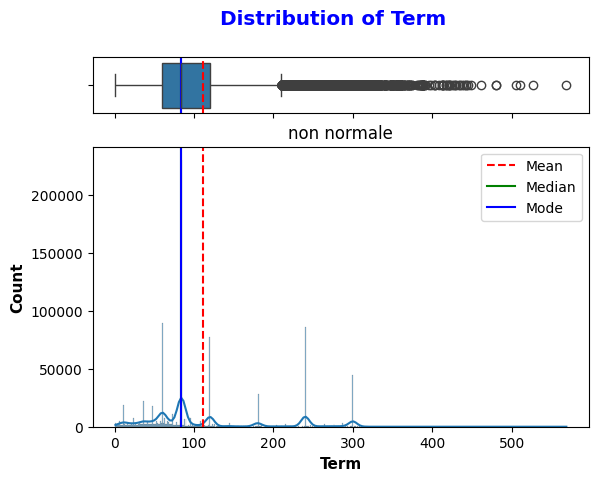

In [3]:
from feature_engine.outliers import OutlierTrimmer
from graph_utils import hist_box_plot

df.drop(df[df.Term == 0].index, inplace=True)

hist_box_plot(df, ('Term'))

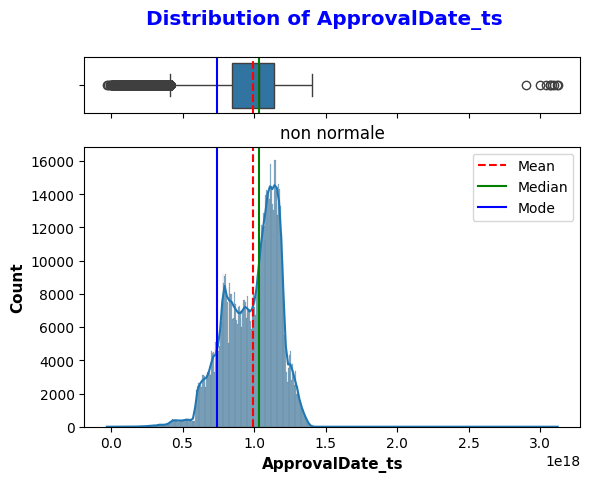

In [4]:
df['ApprovalDate_ts'] = df.ApprovalDate.astype(int)

hist_box_plot(df, ('ApprovalDate_ts'))

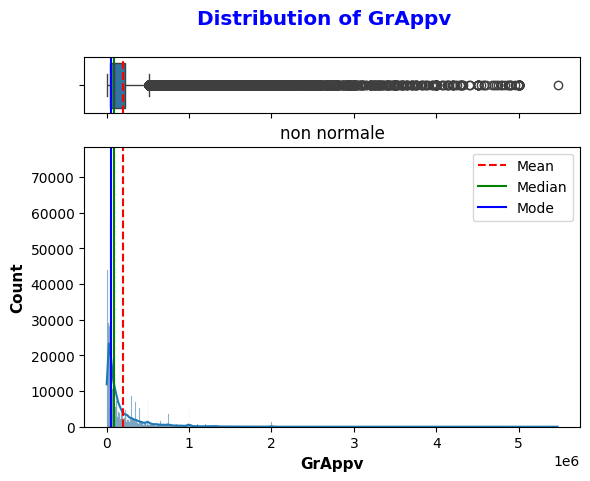

In [5]:
hist_box_plot(df, ('GrAppv'))

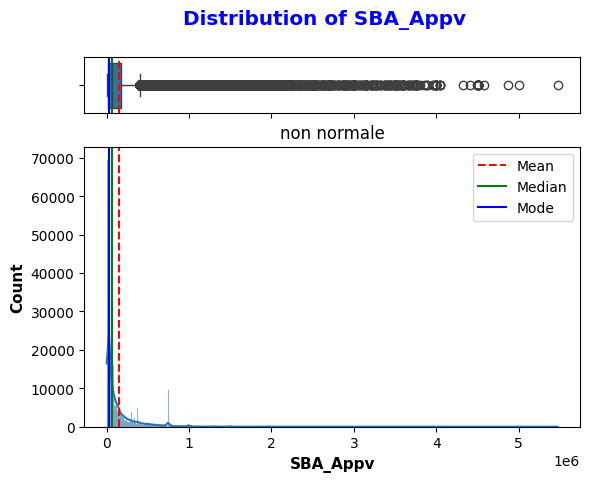

In [6]:
hist_box_plot(df, ('SBA_Appv'))

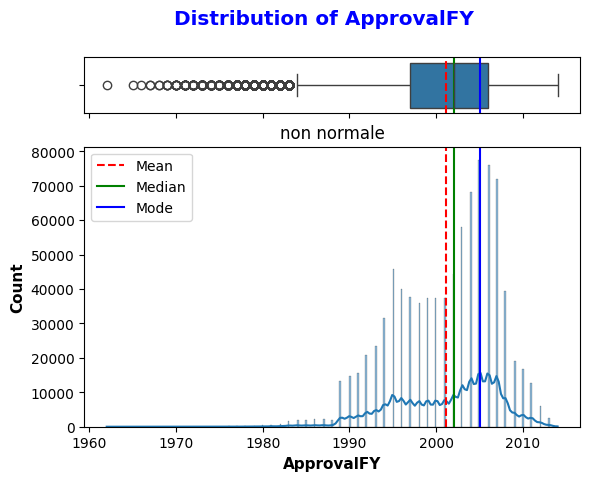

In [7]:

hist_box_plot(df, ('ApprovalFY'))

Les distribution sont non gaussienne, on utilise la méthode des IQR pour supprimer les outliers


In [8]:
ot_r = OutlierTrimmer(capping_method='iqr', tail='right', fold=3, variables=['ApprovalDate_ts'])
ot_l = OutlierTrimmer(capping_method='iqr', tail='left', fold=3, variables=['ApprovalFY'])

#df = ot_r.fit_transform(df)
# df = ot_l.fit_transform(df)

# Feature engenering

In [9]:

df['immo'] = np.where(df['Term'] >= 240, 1, 0)
df['NAICS_enc'] = df.NAICS.astype(object).str[0:1].astype(int)

v = df['BankState'].value_counts()
for idx,name in enumerate(v.index.tolist()):
    if v.iloc[idx] < 10000:
        df.loc[df['BankState'] == name, 'BankState'] = 'unknown'

# Split

In [10]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['MIS_Status'])
y = df.MIS_Status

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.05,
    stratify=y,
    random_state=42
)

X_train.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,ApprovalDate_ts,immo,NAICS_enc
573865,5659833002,"RICHARDSON BIKE MART, INC.",RICHARDSON,TX,75086,AMEGY BK NATL ASSOC,TX,45,1993-04-21,1993,84,22,1,0,0,1,0,0,0,NaN,1993-07-31,375000.0,$0.00,0.0,375000.0,303750.0,735350400000000000,0,4


## pipeline

In [21]:
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures, RobustScaler, StandardScaler
from sklearn.pipeline import FunctionTransformer, make_pipeline
from feature_engine.selection import DropFeatures
from sklearn.feature_selection import SelectFromModel, VarianceThreshold

from xgboost import XGBClassifier

set_config(transform_output = "pandas")

drop_leaking = DropFeatures(features_to_drop=['ChgOffPrinGr', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'BalanceGross'])
drop = DropFeatures(features_to_drop=['BankState', 'ApprovalDate_ts', 'ApprovalDate', 'ApprovalFY', 'LoanNr_ChkDgt', 'Name', 'City', 'Bank', 'State', 'NAICS'])
drop_importance = DropFeatures(features_to_drop=['NAICS_enc', 'CreateJob', 'NoEmp', 'Zip'])

polynomial = PolynomialFeatures(2)

ohe = OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore')

transformers = ColumnTransformer(
    transformers = [
        ('ohe', ohe, ['UrbanRural', 'NewExist', 'LowDoc', 'FranchiseCode', 'RevLineCr']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False)

scaler = StandardScaler()
estimator = XGBClassifier(n_estimators=5, max_depth=7, device='gpu')
#estimator = RandomForestClassifier(max_depth=3)

feature_selection = make_pipeline(
    VarianceThreshold(threshold=.2)
)

pipe = make_pipeline(
            drop_leaking,
            drop_importance,
            drop,
            transformers,
            polynomial,
            scaler,
            feature_selection,
            estimator)

pipe.fit(X_train, y_train)

Pipeline(steps=[('dropfeatures-1',
                 DropFeatures(features_to_drop=['ChgOffPrinGr', 'ChgOffDate',
                                                'DisbursementDate',
                                                'DisbursementGross',
                                                'BalanceGross'])),
                ('dropfeatures-2',
                 DropFeatures(features_to_drop=['NAICS_enc', 'CreateJob',
                                                'NoEmp', 'Zip'])),
                ('dropfeatures-3',
                 DropFeatures(features_to_drop=['BankState', 'ApprovalDate_ts',
                                                'ApprovalDate', 'ApprovalFY',
                                                'Lo...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=5, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [20]:
pipe.score(X_test, y_test)

0.8967229173159981

In [13]:
d = pipe[:-1].fit_transform(X_test, y_test)
display(d.head(1))
print(d.shape)

,UrbanRural_0,UrbanRural_1,UrbanRural_2,NewExist_2,LowDoc_1,FranchiseCode_1,RevLineCr_1,Term,RetainedJob,GrAppv,SBA_Appv,immo,UrbanRural_0^2,UrbanRural_0 NewExist_2,UrbanRural_0 LowDoc_1,UrbanRural_0 FranchiseCode_1,UrbanRural_0 RevLineCr_1,UrbanRural_0 Term,UrbanRural_0 RetainedJob,UrbanRural_0 GrAppv,UrbanRural_0 SBA_Appv,UrbanRural_0 immo,UrbanRural_1^2,UrbanRural_1 NewExist_2,UrbanRural_1 LowDoc_1,UrbanRural_1 FranchiseCode_1,UrbanRural_1 RevLineCr_1,UrbanRural_1 Term,UrbanRural_1 RetainedJob,UrbanRural_1 GrAppv,UrbanRural_1 SBA_Appv,UrbanRural_1 immo,UrbanRural_2^2,UrbanRural_2 NewExist_2,UrbanRural_2 LowDoc_1,UrbanRural_2 FranchiseCode_1,UrbanRural_2 RevLineCr_1,UrbanRural_2 Term,UrbanRural_2 RetainedJob,UrbanRural_2 GrAppv,UrbanRural_2 SBA_Appv,UrbanRural_2 immo,NewExist_2^2,NewExist_2 LowDoc_1,NewExist_2 FranchiseCode_1,NewExist_2 RevLineCr_1,NewExist_2 Term,NewExist_2 RetainedJob,NewExist_2 GrAppv,NewExist_2 SBA_Appv,NewExist_2 immo,LowDoc_1^2,LowDoc_1 FranchiseCode_1,LowDoc_1 RevLineCr_1,LowDoc_1 Term,LowDoc_1 RetainedJob,LowDoc_1 GrAppv,LowDoc_1 SBA_Appv,LowDoc_1 immo,FranchiseCode_1^2,FranchiseCode_1 RevLineCr_1,FranchiseCode_1 Term,FranchiseCode_1 RetainedJob,FranchiseCode_1 GrAppv,FranchiseCode_1 SBA_Appv,FranchiseCode_1 immo,RevLineCr_1^2,RevLineCr_1 Term,RevLineCr_1 RetainedJob,RevLineCr_1 GrAppv,RevLineCr_1 SBA_Appv,RevLineCr_1 immo,Term^2,Term RetainedJob,Term GrAppv,Term SBA_Appv,Term immo,RetainedJob^2,RetainedJob GrAppv,RetainedJob SBA_Appv,RetainedJob immo,GrAppv^2,GrAppv SBA_Appv,GrAppv immo,SBA_Appv^2,SBA_Appv immo,immo^2
470054,-0.750744,0.954462,-0.362698,-0.627466,-1.326946,0.545913,-0.691659,1.81815,-0.046122,2.177549,2.023774,2.222779,-0.750744,-0.330945,-0.490184,-0.707579,-0.183356,-0.588595,-0.030978,-0.432627,-0.454372,-0.315825,0.954462,-0.411995,-0.759066,1.355487,-0.569655,2.898137,-0.22516,3.036945,2.820093,3.855707,-0.362698,-0.200564,-0.291866,-0.303477,-0.21974,-0.290405,-0.122507,-0.182411,-0.172581,-0.121741,-0.627466,-0.492698,-0.512888,-0.292449,-0.496024,-0.017457,-0.295308,-0.289458,-0.178567,-1.326946,-0.914582,-0.59715,-0.926008,-0.031636,-0.876998,-0.785803,-0.159326,0.545913,-0.544229,1.851377,-0.212364,2.419368,2.276136,2.357814,-0.691659,-0.51535,-0.163379,-0.265639,-0.2374,-0.146358,1.832288,-0.036129,2.595398,2.428016,2.121268,-0.028607,-0.045686,-0.042182,-0.027733,1.177808,1.106766,3.036902,0.950474,2.739571,2.222779


(44918, 87)


## Score

In [22]:
from sklearn.metrics import classification_report

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

y_pred_train = pipe.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.85      0.71      0.78      7841
           1       0.94      0.97      0.96     37077

    accuracy                           0.93     44918
   macro avg       0.90      0.84      0.87     44918
weighted avg       0.93      0.93      0.93     44918

              precision    recall  f1-score   support

           0       0.85      0.71      0.77    148983
           1       0.94      0.97      0.96    704453

    accuracy                           0.93    853436
   macro avg       0.89      0.84      0.87    853436
weighted avg       0.92      0.93      0.92    853436



## Matrice de confusion

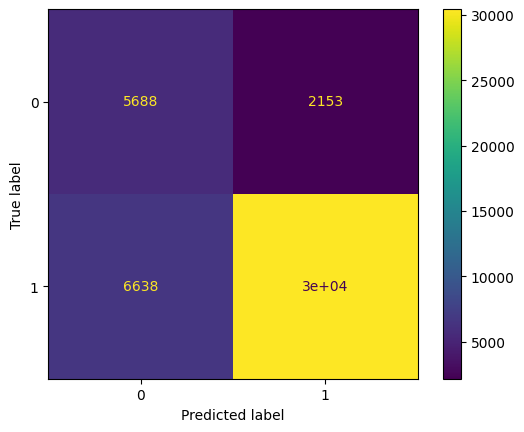

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cf_matrix).plot()

## Feature importance

                        features  score %
0                           Term    25.73
1   UrbanRural_0 FranchiseCode_1    13.13
2          UrbanRural_1 LowDoc_1     8.71
3           FranchiseCode_1 Term     7.51
4                LowDoc_1 GrAppv     7.38
..                           ...      ...
82  UrbanRural_2 FranchiseCode_1     0.00
83         UrbanRural_2 LowDoc_1     0.00
84       UrbanRural_2 NewExist_2     0.00
85                UrbanRural_2^2     0.00
86                        immo^2     0.00

[87 rows x 2 columns]


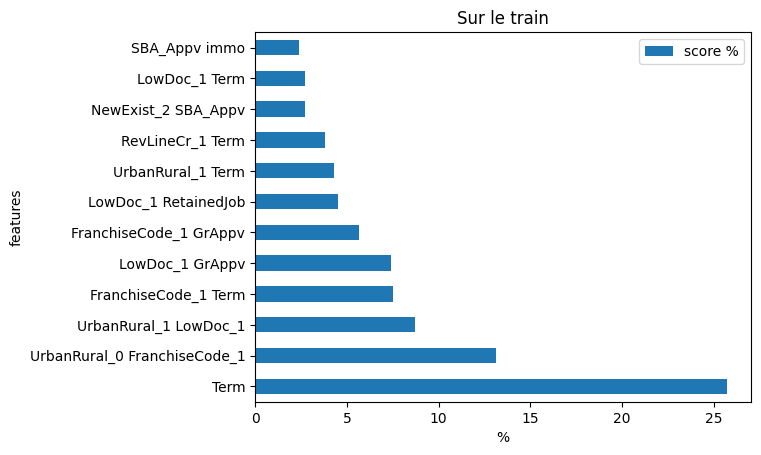

In [16]:
from utils import feature_importance
from matplotlib import pyplot as plt


f, X_train_transf = feature_importance(X_train, y_train, pipe)
#print(X_train_transf.isna().sum())
print(f)
f.loc[f['score %'] > 2].plot.barh(y='score %', x='features')
plt.title('Sur le train')
plt.xlabel('%')
plt.legend()

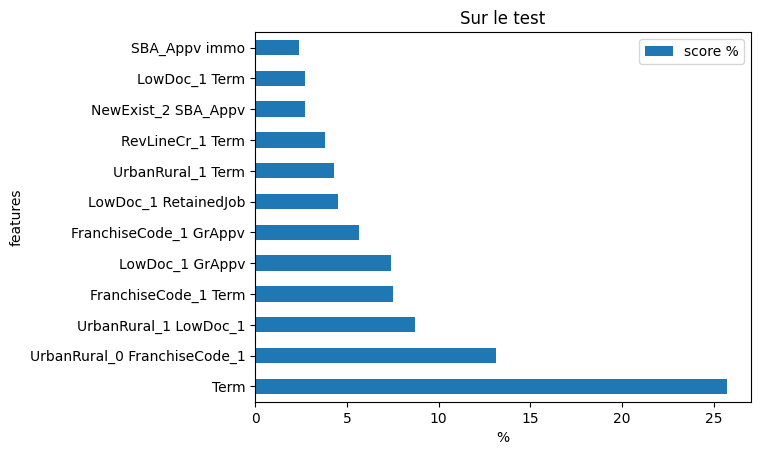

In [17]:
from matplotlib import pyplot as plt
f, X_test_transf = feature_importance(X_test, y_test, pipe)

f.loc[f['score %'] > 2].plot.barh(y='score %', x='features')
plt.title('Sur le test')
plt.xlabel('%')
plt.legend()

In [18]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = model,
    X = X_train_transf,
    y = y_train,
    train_sizes = np.linspace(0.01, 1, 10),
    cv = 3,
    scoring = 'f1_macro',
    n_jobs=-1
)

NameError: name 'model' is not defined

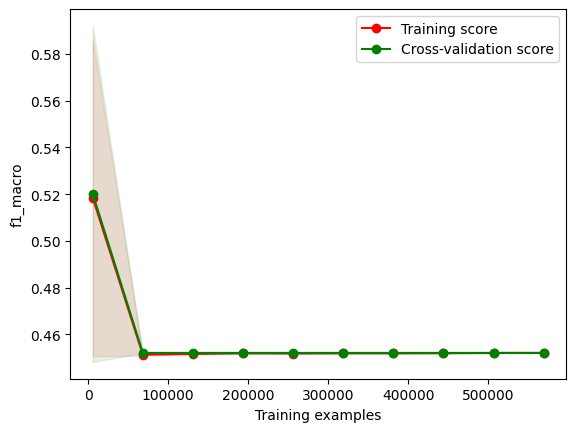

In [ ]:
import matplotlib.pyplot as plt

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(validation_scores, axis=1)
test_std = np.std(validation_scores, axis=1)

# afficher les points
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

# relier les points
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

plt.xlabel("Training examples")
plt.ylabel("f1_macro")

plt.legend()